In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import MNIST, FashionMNIST
import torchvision.transforms as transforms
import torchaudio
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm
import cv2
from copy import deepcopy
from IPython.display import Audio, display
from scipy.io.wavfile import write
from torchmetrics.audio import ScaleInvariantSignalDistortionRatio, ScaleInvariantSignalNoiseRatio

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
class VAELoss(nn.Module):
    def __init__(self):
        super(VAELoss, self).__init__()
        self.mse = nn.MSELoss(reduction = 'sum')

    def forward(self, y_pred, y_true, mean1, var1, mean2, var2):
        mse = self.mse(y_pred, y_true)
        kullback1 = -0.5 * (1 + var1 - mean1**2 - var1.exp()).sum()
        kullback2 = -0.5 * (1 + var2 - mean2**2 - var2.exp()).sum()
        return mse + kullback1 + kullback2

In [5]:
def train_model(model, train_data, criterion, optimizer, epochs, val_data, device = device):
    model.to(device)
    best = model.state_dict()
    min_val = 10
    model.train()
    tr_l, v_l = [], []
    for epoch in range(epochs):
        tr_loss = 0
        tr_acc = 0
        val_loss = 0
        val_acc = 0
        model.train()
        for images, labels in tqdm(train_data):
            images = images.to(device)
            labels = labels.to(device)
            preds, c1, c2, mean1, var1, mean2, var2 = model(images)
            loss = criterion(preds, labels, mean1, var1, mean2, var2)
            tr_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        model.eval()
        for images, labels in val_data:
            images = images.to(device)
            labels = labels.to(device)
            preds, c1, c2, mean1, var1, mean2, var2 = model(images)
            loss = criterion(preds, labels, mean1, var1, mean2, var2)
            val_loss += loss.item()
        tr_loss /= len(train_data)
        val_loss /= len(val_data)
        tr_l.append(tr_loss)
        v_l.append(val_loss)
        print(f'epoch: {epoch} loss: {tr_loss} val_loss: {val_loss}')
        if val_loss < min_val:
            min_val = val_loss
            best = deepcopy(model.state_dict())
    model.load_state_dict(best)
    return tr_l, v_l

In [ ]:
from glob import glob
# set the dataset name
file_names = glob('./voi/*.wav')
train_files, test_files = train_test_split(file_names)

In [ ]:
class AudioData(Dataset):
    def __init__(self, file_names):
        self.file_names = file_names
        self.transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    def __len__(self):
        return len(self.file_names)
    def __getitem__(self, idx):
        file_path = self.file_names[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        waveform = torchaudio.transforms.Resample(sample_rate, 44100)(waveform)
        spectro = torchaudio.transforms.Spectrogram(n_fft = 512)(waveform.mean(0))
        spectro = torchaudio.transforms.AmplitudeToDB(top_db = 80)(spectro)

        return spectro[None], spectro[None]

In [ ]:
train_ds = AudioData(train_files)
train_data = DataLoader(train_ds, batch_size = 8)

val_ds = AudioData(test_files)
val_data = DataLoader(val_ds)
# sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
class ConvEncoder(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(ConvEncoder, self).__init__()
        self.in2h = nn.Sequential(nn.Conv2d(in_dim, 32, 3, 1, padding = 1), nn.ReLU(),
                                  nn.Conv2d(32, 64, 3, 2, padding = 1), nn.ReLU(),
                                  nn.Conv2d(64, 128, 3, 1, padding = 1), nn.ReLU(),
                                  nn.Conv2d(128, 128, 3, 2, padding = 1), nn.ReLU(),
                                  nn.Conv2d(128, 256, 3, 1, padding = 1), nn.ReLU(),
                                  nn.Conv2d(256, 256, 3, 2, padding = 1), nn.ReLU(),
                                  nn.Conv2d(256, 256, 3, 1, padding = 1), nn.ReLU(),
                                  nn.Conv2d(256, 256, 3, 2, padding = 1), nn.ReLU(),)
        self.h2mean1 = nn.Conv2d(256, out_dim, 1, 1, padding = 0)
        self.h2var1 = nn.Conv2d(256, out_dim, 1, 1, padding = 0)
        self.h2mean2 = nn.Conv2d(256, out_dim, 1, 1, padding = 0)
        self.h2var2 = nn.Conv2d(256, out_dim, 1, 1, padding = 0)

    def forward(self, x):
        hidden = self.in2h(x)
        mean1 = self.h2mean1(hidden)
        var1 = self.h2var1(hidden)
        mean2 = self.h2mean2(hidden)
        var2 = self.h2var2(hidden)
        return mean1, var1, mean2, var2

class ConvDecoder(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(ConvDecoder, self).__init__()
        self.in2out = nn.Sequential(nn.Upsample(scale_factor = 2),
                                    nn.Conv2d(in_dim, 256, 3, 1, padding = 1), nn.ReLU(),
                                    nn.Conv2d(256, 256, 3, 1, padding = 1), nn.ReLU(),
                                    nn.Upsample(scale_factor = 2),
                                    nn.Conv2d(256, 128, 3, 1, padding = 1), nn.ReLU(),
                                    nn.Conv2d(128, 128, 3, 1, padding = 1), nn.ReLU(),
                                    nn.Upsample(scale_factor = 2),
                                    nn.Conv2d(128, 128, 3, 1, padding = 1), nn.ReLU(),
                                    nn.Conv2d(128, 64, 3, 1, padding = 1), nn.ReLU(),
                                    nn.Upsample(scale_factor = 2),
                                    nn.AdaptiveAvgPool2d((257, 517)),
                                    nn.Conv2d(64, 64, 3, 1, padding = 1), nn.ReLU(),
                                    nn.Conv2d(64, out_dim, 3, 1, padding = 1))

    def forward(self, x):
        return self.in2out(x)

class ConVAE(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim):
        super(ConVAE, self).__init__()
        self.encoder = ConvEncoder(in_dim, h_dim, out_dim)
        self.decoder1 = ConvDecoder(out_dim, h_dim, in_dim)
        self.decoder2 = ConvDecoder(out_dim, h_dim, in_dim)

    def forward(self, x):
        mean1, var1, mean2, var2 = self.encoder(x)
        new_samples1 = mean1 + torch.randn_like(var1) * var1.exp().sqrt()
        new_samples2 = mean2 + torch.randn_like(var2) * var2.exp().sqrt()
        recons1 = self.decoder1(new_samples1)
        recons2 = self.decoder2(new_samples2)
        recons = (recons1 + recons2) * 0.5
        return recons, recons1, recons2, mean1, var1, mean2, var2

In [ ]:
model = ConVAE(1, 64, 256)
criterion = VAELoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [ ]:
a,b = train_model(model, train_data, criterion, optimizer, 20, val_data, device = device)

  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 0 loss: 285371829.4794521 val_loss: 9788095.743589744


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 1 loss: 63141299.17808219 val_loss: 6528211.569230769


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 2 loss: 47727770.95890411 val_loss: 5711896.425641025


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 3 loss: 45513253.64383562 val_loss: 5489982.821794872


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 4 loss: 43169372.60273973 val_loss: 5292020.407692308


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 5 loss: 42072264.38356164 val_loss: 5175712.262820513


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 6 loss: 43508005.36986301 val_loss: 5136989.344871795


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 7 loss: 40644401.36986301 val_loss: 5045823.865384615


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 8 loss: 40516647.09589041 val_loss: 4992197.024358975


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 9 loss: 39649044.1369863 val_loss: 4935006.566666666


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 10 loss: 39467622.52054795 val_loss: 4891931.687179487


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 11 loss: 41534338.1369863 val_loss: 4872021.96025641


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 12 loss: 38705339.69863014 val_loss: 4805303.757692307


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 13 loss: 38399329.15068493 val_loss: 4789979.657692308


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 14 loss: 38635840.05479452 val_loss: 4814418.475641025


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 15 loss: 38030899.47945205 val_loss: 4800548.537179487


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 16 loss: 37901492.10958904 val_loss: 4724137.341666667


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 17 loss: 38953923.83561644 val_loss: 4677012.384615385


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 18 loss: 37122879.5890411 val_loss: 4634308.935897436


  0%|          | 0/73 [00:00<?, ?it/s]

epoch: 19 loss: 37115722.90410959 val_loss: 4624663.1


In [ ]:
plt.plot(a)

In [1]:
train_loss = [285371829.4794521, 63141299.17808219, 47727770.95890411, 45513253.64383562, 43169372.60273973,
  42072264.38356164, 43508005.36986301, 40644401.36986301, 40516647.09589041, 39649044.1369863,
    39467622.52054795, 41534338.1369863 , 38705339.69863014,38399329.15068493,38635840.05479452,
      38030899.47945205,37901492.10958904,38953923.83561644,37122879.5890411 , 37115722.90410959]

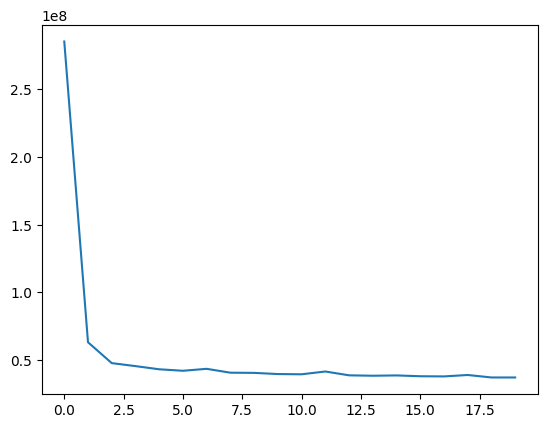

In [2]:
import matplotlib.pyplot as plt
plt.plot(train_loss)

In [3]:

val_loss = [9788095.743589744,
6528211.569230769,
5711896.425641025,
5489982.821794872,
5292020.407692308,
5175712.262820513,
5136989.344871795,
5045823.865384615,
4992197.024358975,
4935006.566666666,
4891931.68717948,
4872021.96025641,
4805303.75769230,
4789979.65769230,
4814418.47564102,
4800548.53717948,
4724137.34166666,
4677012.38461538,
4634308.935897436,
4624663.1]

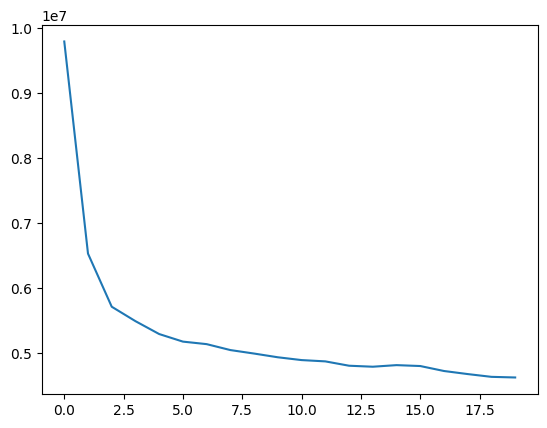

In [4]:
import matplotlib.pyplot as plt
plt.plot(val_loss)

In [ ]:
plt.plot(b)

  0%|          | 0/195 [00:00<?, ?it/s]

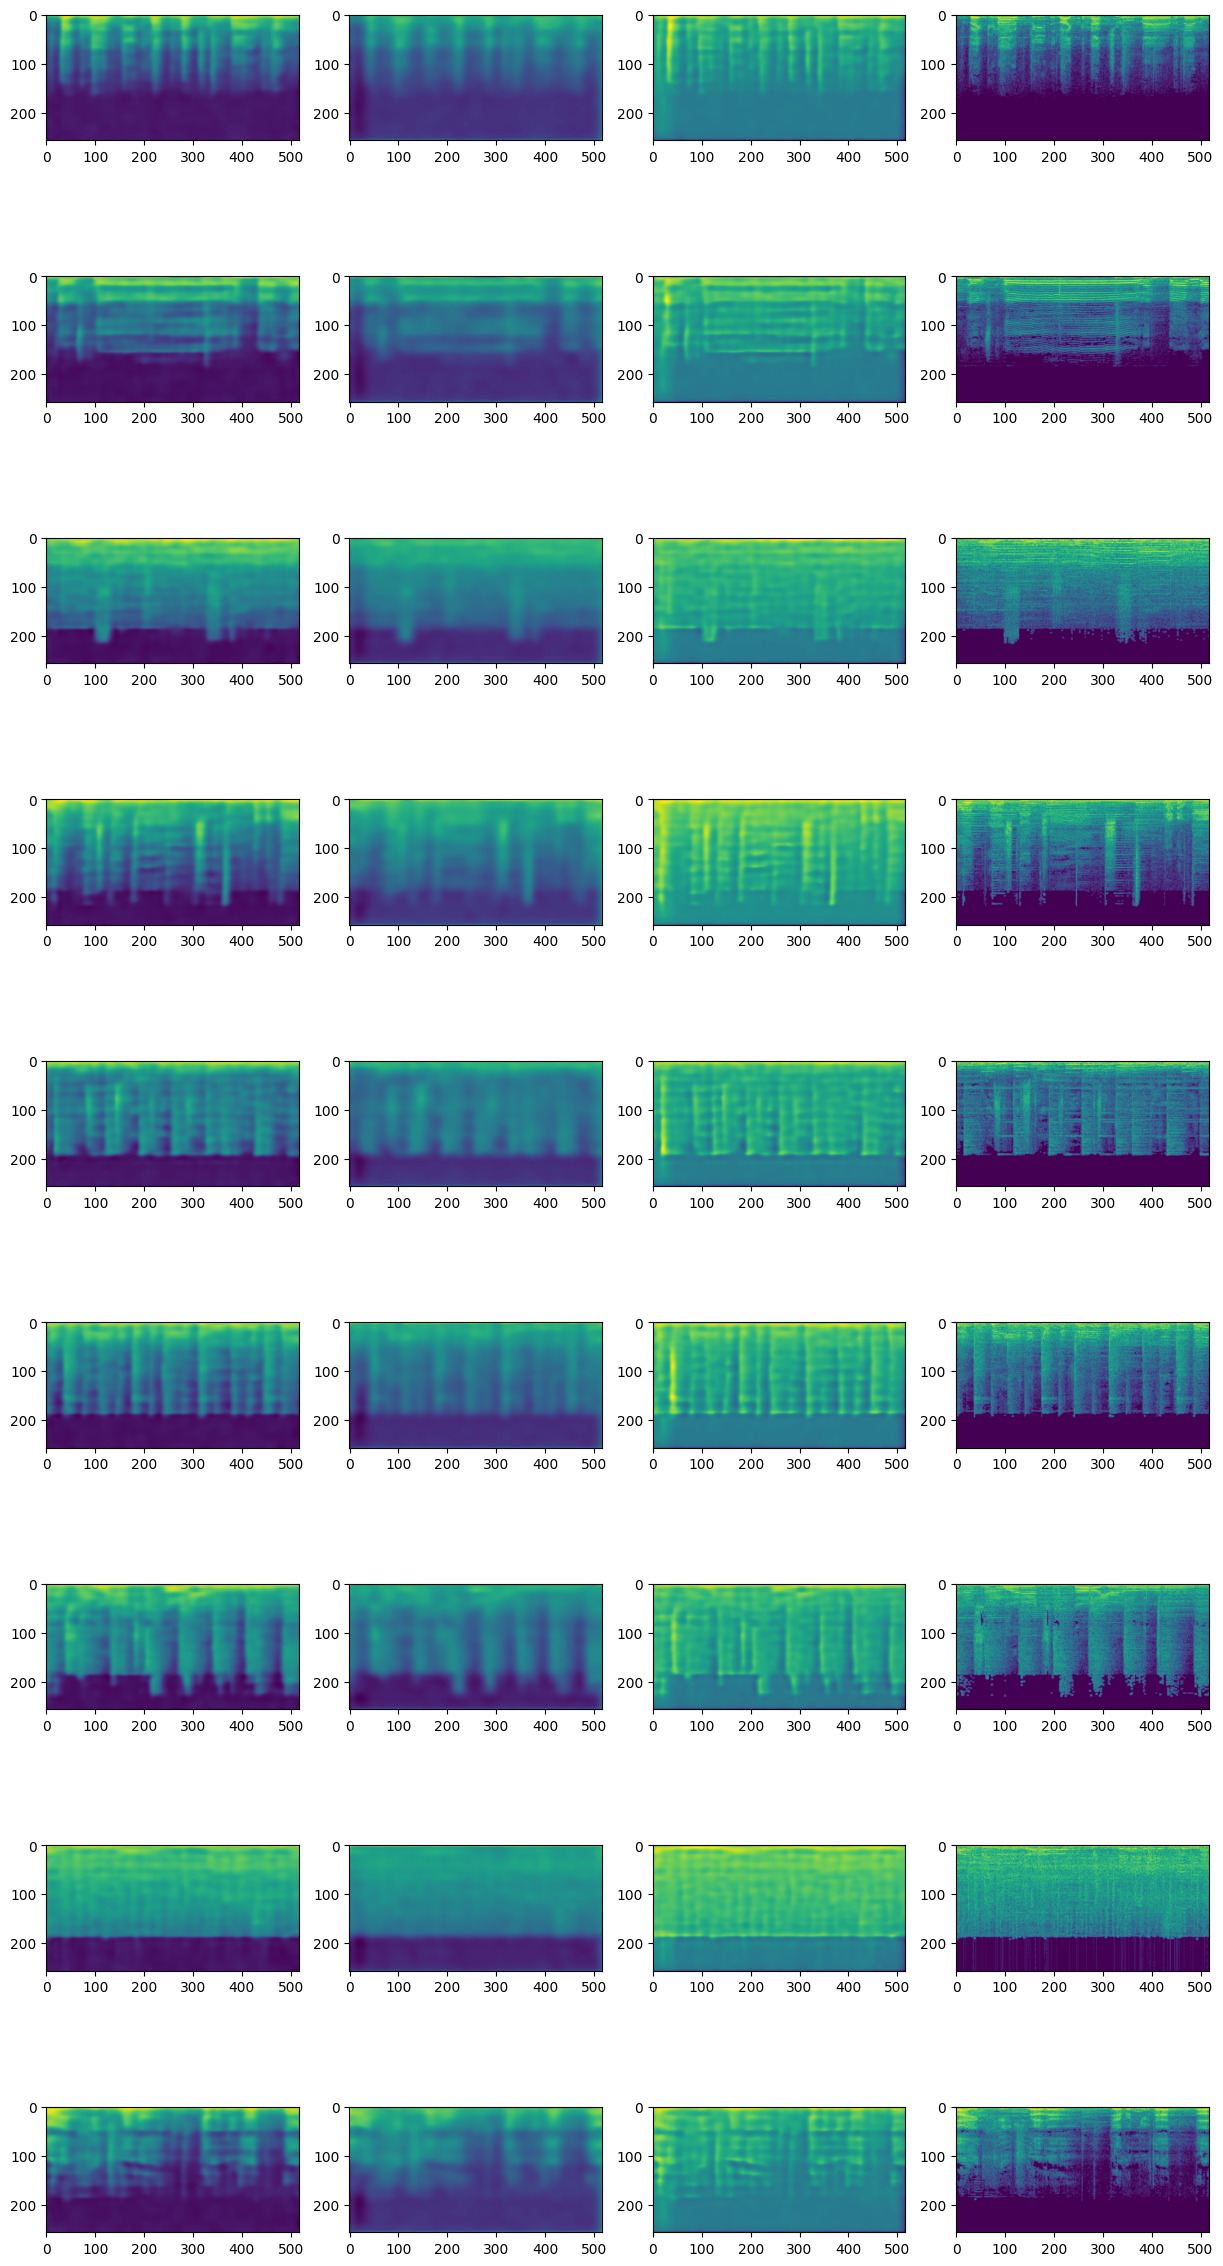

In [ ]:
i = 0
plt.figure(figsize = (15, 30))
for images, labels in tqdm(val_data):
    if i > 8:
        break
    images = images.to(device)
    labels = labels.to(device)
    preds, recons1, recons2, mean1, var1, mean2, var2 = model(images)
    preds = preds.detach().cpu().numpy()
    c1 = recons1.detach().cpu().numpy()
    c2 = recons2.detach().cpu().numpy()
    plt.subplot(9, 4, 4 * i + 1)
    plt.imshow(preds.squeeze())
    plt.subplot(9, 4, 4 * i + 2)
    plt.imshow(c1.squeeze())
    plt.subplot(9, 4, 4 * i + 3)
    plt.imshow(c2.squeeze())
    plt.subplot(9, 4, 4 * i + 4)
    plt.imshow(images[0].cpu().numpy().reshape((257,517)))
    i += 1